#Number of Apple in an image of Apple in an Orchards

In [ ]:
!python --version

Python 3.7.12


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Downloading Dataset from Source and Extracing locally

In [ ]:
!wget https://conservancy.umn.edu/bitstream/handle/11299/206575/detection.tar.gz?sequence=2&isAllowed=y

--2022-01-07 04:22:59--  https://conservancy.umn.edu/bitstream/handle/11299/206575/detection.tar.gz?sequence=2
Resolving conservancy.umn.edu (conservancy.umn.edu)... 128.101.122.105
Connecting to conservancy.umn.edu (conservancy.umn.edu)|128.101.122.105|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 1825397590 (1.7G) [application/gzip]
Saving to: ‘detection.tar.gz?sequence=2’

detection.tar.gz?se 100%[===================>]   1.70G  7.61MB/s    in 5m 59s  

2022-01-07 04:28:58 (4.85 MB/s) - ‘detection.tar.gz?sequence=2’ saved [1825397590/1825397590]



In [ ]:
!tar --gunzip --extract --verbose --file=detection.tar.gz?sequence=2

Installing Required Libraries

In [ ]:
! pip install torch torchvision
! pip install matplotlib
! pip install opencv-contrib-python
! pip install imutils
! pip install scikit-learn
! pip install tqdm

Importing Required Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import numpy as np
import torch

Generating List of image file names

In [ ]:
train_path = "/content/detection/train"
test_path = "/content/detection/test"

In [ ]:
train_image = list(sorted(os.listdir(os.path.join(train_path,"images"))))
train_mask = list(sorted(os.listdir(os.path.join(train_path,"masks"))))
test_image = list((os.listdir(os.path.join(test_path,"images"))))

test1 = (os.path.join(train_path,"images","20150919_174151_image6.png"))
test2 = (os.path.join(train_path,"images","20150919_174151_image51.png"))
test3 = (os.path.join(train_path,"images","20150921_132038_image1386.png"))
test4 = (os.path.join(train_path,"images","20150921_132038_image926.png"))

test=list([test1,test2,test3,test4])


dataset_length = len(train_image)
test_length = len(test_image)

print(test[1])

/content/detection/train/images/20150919_174151_image51.png


In [ ]:
#Change to resize original image to size accordingly
img_width = 256
img_height = 256
img_channel = 3

In [ ]:
for i in range(10):
  print(train_image[i])

20150919_174151_image1.png
20150919_174151_image101.png
20150919_174151_image106.png
20150919_174151_image11.png
20150919_174151_image111.png
20150919_174151_image116.png
20150919_174151_image121.png
20150919_174151_image126.png
20150919_174151_image131.png
20150919_174151_image136.png


Generate Image Dataloader

In [ ]:
X_train = np.zeros((dataset_length,img_width, img_height,  img_channel), dtype = np.uint8)
Y_train = np.zeros((dataset_length,img_width, img_height,1), dtype = np.bool)

X_test = np.zeros((4,img_width, img_height,  img_channel), dtype = np.uint8)


for idx in range(dataset_length):
  img_path = os.path.join(train_path,"images",train_image[idx])
  img = cv2.imread(img_path)[:,:,:img_channel]       
  img = cv2.resize(img, (img_height,img_width))
  X_train[idx] = img

  mask_ = np.zeros((img_width, img_height,1), dtype=np.bool)

  mask_path = os.path.join(train_path, "masks", train_mask[idx])
  mask = cv2.imread(mask_path)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) 
  (thresh, mask_b) = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)  
  mask_b = np.expand_dims(cv2.resize(mask_b, (img_height, img_width)),axis=-1)
  mask_=np.maximum(mask_,mask_b)
  Y_train[idx] = mask_

for i in range(4):
  img_path = test[i]
  img = cv2.imread(img_path)[:,:,:img_channel]       
  img = cv2.resize(img, (img_height,img_width))
  X_test[i] = img

#Convert Mask into binary
Y_train_binary = 255*Y_train.astype(int)


Visualise Image and Mask

[  0 255]


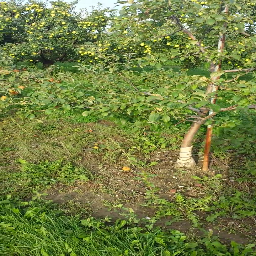

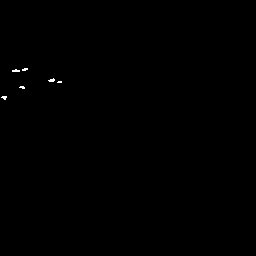

In [ ]:
from google.colab.patches import cv2_imshow

image_x = random.randint(0,dataset_length)
print(np.unique(Y_train_binary[idx]))
cv2_imshow(X_train[image_x])
plt.show()
cv2_imshow(np.squeeze(Y_train_binary[image_x]))
plt.show()





Connected Component Analysis to separate mask apple from image for VISUALISATION

[Info] examining component 1/7 (background)


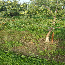

[Info] examining component 2/7


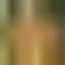

[Info] examining component 3/7


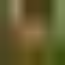

[Info] examining component 4/7


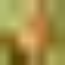

[Info] examining component 5/7


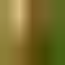

[Info] examining component 6/7


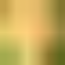

[Info] examining component 7/7


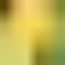

In [ ]:
output = cv2.connectedComponentsWithStats(np.uint8(Y_train[image_x]), 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

for i in range(numLabels):
  if i==0:
    text = "examining component {}/{} (background)".format(i + 1, numLabels)
  else:
    text = "examining component {}/{}".format(i + 1, numLabels)
  print("[Info] {}".format(text) )
  x = stats[i, cv2.CC_STAT_LEFT]
  y = stats[i, cv2.CC_STAT_TOP]
  w = stats[i, cv2.CC_STAT_WIDTH]
  h = stats[i, cv2.CC_STAT_HEIGHT]
  output = X_train[image_x].copy()
  crop_img = output[y:y+h, x:x+w]
  crop_img = cv2.resize(crop_img, (65, 65))
  cv2_imshow(crop_img)
  cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
  componentMask = (labels == i).astype("uint8") * 255

#U-Net Model for Apple Segmentation

In [ ]:
import tensorflow as tf


inputs = tf.keras.layers.Input((img_width,img_height,img_channel))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) #Normalising and converting image into floating point

#Contracting Path
c1 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)


#Expansive Path
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)


u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)


u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis = 3)
c9 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)


outputs = tf.keras.layers.Conv2D(1,(1,1), activation="sigmoid")(c9)

model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("Apple_detection.h5", verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir="logs")]

In [ ]:
results = model.fit(X_train, Y_train, validation_split = 0.1, batch_size=32, epochs=25, callbacks=callbacks )

Epoch 1/25
19/19 [==============================] - 430s 23s/step - loss: 0.2380 - accuracy: 0.9712 - val_loss: 0.1019 - val_accuracy: 0.9841
Epoch 2/25
19/19 [==============================] - 440s 23s/step - loss: 0.1630 - accuracy: 0.9720 - val_loss: 0.0914 - val_accuracy: 0.9841
Epoch 3/25
19/19 [==============================] - 447s 24s/step - loss: 0.1267 - accuracy: 0.9720 - val_loss: 0.0791 - val_accuracy: 0.9841
Epoch 4/25
19/19 [==============================] - 446s 23s/step - loss: 0.0959 - accuracy: 0.9720 - val_loss: 0.0779 - val_accuracy: 0.9844
Epoch 5/25
19/19 [==============================] - 444s 23s/step - loss: 0.0782 - accuracy: 0.9729 - val_loss: 0.0537 - val_accuracy: 0.9861
Epoch 6/25
19/19 [==============================] - 428s 23s/step - loss: 0.0678 - accuracy: 0.9763 - val_loss: 0.0478 - val_accuracy: 0.9834
Epoch 7/25
19/19 [==============================] - 438s 23s/step - loss: 0.0616 - accuracy: 0.9794 - val_loss: 0.0556 - val_accuracy: 0.9796
Epoch 

Save and Load for future *use*

In [ ]:
!mkdir -p saved_model_Segmentation
model.save('/content/gdrive/MyDrive/Colab Notebooks/ML Tutorial/saved_model_Segmentation/Apple_segmentation')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ML Tutorial/saved_model_Segmentation/Apple_segmentation/assets


In [ ]:
new_model_segmentation = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/ML Tutorial/saved_model_Segmentation/Apple_segmentation')

# Check its architecture
new_model_segmentation.summary()

In [ ]:

plot_model(new_model_segmentation, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#Visualise Segmentation Results

In [ ]:
idx = random.randint(0,len(X_train))

In [ ]:
preds_train = new_model_segmentation.predict(X_train[:int(X_train.shape[0]*0.9)])
# preds_train = new_model_segmentation.predict(X_train)

In [ ]:
preds_train = (preds_train>0.5).astype(np.uint8)

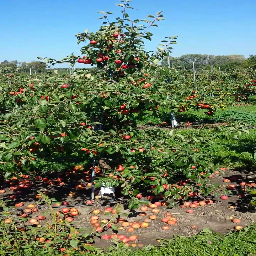

Image


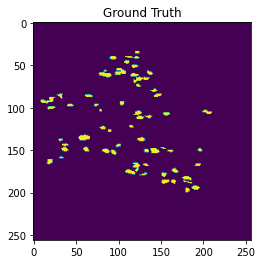

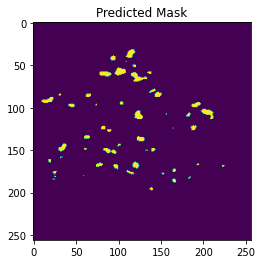

In [ ]:
ix = random.randint(0,len(preds_train))
cv2_imshow(X_train[ix])
print("Image")
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.title("Ground Truth")
plt.show()
plt.imshow(np.squeeze(preds_train[ix]))
plt.title("Predicted Mask")
plt.show()

In [ ]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
X_test = np.zeros((4,img_width, img_height,  img_channel), dtype = np.uint8)
test = [test1, test2, test3, test4]
for idx in range(4):
  img_path =test[idx]
  img = cv2.imread(img_path)[:,:,:img_channel]       
  img = cv2.resize(img, (img_height,img_width))
  X_test[idx] = img


In [ ]:
preds_test = new_model_segmentation.predict(X_test)
# preds_val = new_model_segmentation.predict(X_train[int(X_train.shape[0]*0.9:)])

In [ ]:
preds_test_t = (preds_test>0.7).astype(np.uint8)

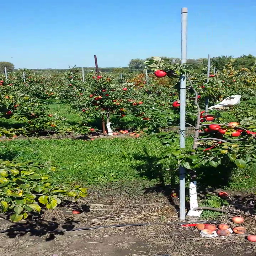

3


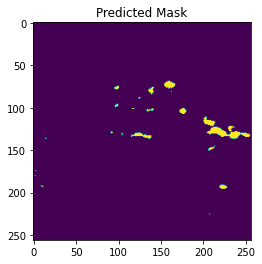

In [ ]:
ix = 3
cv2_imshow(X_test[ix])
print(ix)
plt.show()
plt.imshow(np.squeeze(preds_test_t[ix]))
plt.title("Predicted Mask")
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score

In [ ]:
print(preds_train.shape)

(670, 256, 256, 1)


In [ ]:

Y_pred = preds_train.flatten()
Y = Y_train.flatten()
#print(preds)
#print(Y)

In [ ]:
matx = confusion_matrix(Y,Y_pred)
f1_sc = f1_score(Y,Y_pred,average="weighted")
precision = precision_score(Y,Y_pred,average="macro")
recall = recall_score(Y,Y_pred,average="macro")
accuracy = accuracy_score(Y,Y_pred)

In [ ]:
print("connfusion matrix\n---------------------------------------------------------------------------------------------\n")
print(matx)
print("\n---------------------------------------------------------------------------------------------\n")
print("f1 score: "+str(f1_sc))
print("precision: "+str(precision))
print("recall: "+str(recall))
print("accuracy: "+ str(accuracy))

connfusion matrix
---------------------------------------------------------------------------------------------

[[42430333   303190]
 [  475935   699662]]

---------------------------------------------------------------------------------------------

f1 score: 0.9815703334225016
precision: 0.843289901757952
recall: 0.7940298668823452
accuracy: 0.9822559641368354


In [ ]:
X_val = np.zeros((dataset_length,img_width, img_height,  img_channel), dtype = np.uint8)

test = [test1, test2, test3, test4]

for idx in range(4):
  img_path = test[idx]
  img = cv2.imread(img_path)[:,:,:img_channel]       
  img = cv2.resize(img, (img_height,img_width))
  X_val[idx] = img

In [ ]:
preds_val= new_model_segmentation.predict(X_val)

In [ ]:
# ix = random.randint(0,len(preds_test_t))
cv2_imshow(X_val[1])
plt.show()

plt.imshow(np.squeeze(preds_val[1]))
plt.show()

NameError: ignored

#Loading a Counting Model from drive 

In [ ]:
new_model_counting = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/ML Tutorial/saved_model/Apple_counting')

# Check its architecture
new_model_counting.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65, 65, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 65, 65, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 65, 65, 16)        448       
                                                                 
 dropout (Dropout)           (None, 65, 65, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                             

#Results

Calculating Total Apples in an image using U-Net Semantic Segmantation and Classification Counting Network

[Info] examining component 1/22 (background)


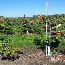

[Info] examining component 2/22


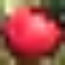

1
[Info] examining component 3/22


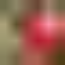

1
[Info] examining component 4/22


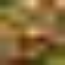

4
[Info] examining component 5/22


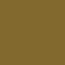

4
[Info] examining component 6/22


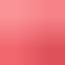

4
[Info] examining component 7/22


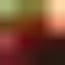

3
[Info] examining component 8/22


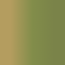

0
[Info] examining component 9/22


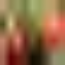

5
[Info] examining component 10/22


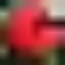

2
[Info] examining component 11/22


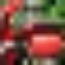

5
[Info] examining component 12/22


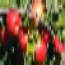

4
[Info] examining component 13/22


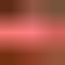

1
[Info] examining component 14/22


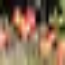

2
[Info] examining component 15/22


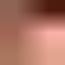

2
[Info] examining component 16/22


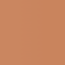

4
[Info] examining component 17/22


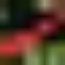

2
[Info] examining component 18/22


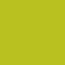

1
[Info] examining component 19/22


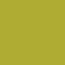

1
[Info] examining component 20/22


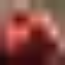

1
[Info] examining component 21/22


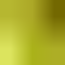

0
[Info] examining component 22/22


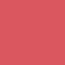

4


In [ ]:
output = cv2.connectedComponentsWithStats(np.uint8(np.squeeze(preds_test_t[ix])), 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output
Total=0
for i in range(numLabels):
  X_ans=[]
  if i==0:
    text = "examining component {}/{} (background)".format(i + 1, numLabels)
  else:
    text = "examining component {}/{}".format(i + 1, numLabels)
  print("[Info] {}".format(text) )
  x = stats[i, cv2.CC_STAT_LEFT]
  y = stats[i, cv2.CC_STAT_TOP]
  w = stats[i, cv2.CC_STAT_WIDTH]
  h = stats[i, cv2.CC_STAT_HEIGHT]
  output = X_test[ix].copy()
  crop_img = output[y:y+h, x:x+w]
  crop_img = cv2.resize(crop_img, (65, 65))
  cv2_imshow(crop_img)
  cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
  componentMask = (labels == i).astype("uint8") * 255
  if i!=0:
    X_ans.append(crop_img)
    X_ans = np.array(X_ans)
    preds_test = new_model_counting.predict(X_ans)
    print(np.argmax(preds_test))
    Total+=np.argmax(preds_test)


Total Apples in an Orchard

In [ ]:
print(Total)

51
